<a href="https://colab.research.google.com/github/01PrathamS/make_more/blob/main/MLP_approach_biagram_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('make_more_names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [87]:
block_size = 3
def build_dataset(words):
  X, y = [], []
  # for w in words[:5]:
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix]
  X = torch.tensor(X)
  y = torch.tensor(y)
  return X, y

X , y = build_dataset(words)
X.shape, y.shape


(torch.Size([228146, 3]), torch.Size([228146]))

In [47]:
C = torch.randn((27, 2))

In [48]:
C[5]

tensor([-0.0136,  0.0359])

this is one way to doing it

In [14]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 0.4727, -0.0610])

In [15]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C  == C[5]

tensor([True, True])

we are doing indexing because it is much more faster & PyTorch indexig is awesome

In [49]:
## embedding matrix for input data

emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [50]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [ ]:
emb @ W1 + b1

In [20]:
# i need to fix the shape first there are many ways to do it

# torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape ## ((32, 6))

# torch.cat(torch.unbind(emb, 1), 1).shape ## ((32, 6))

# emb.view(32, 6)

In [21]:
## h = hidden states

# h = emb.view(emb.shape[0], 6) @ W1 + b1
h = emb.view(-1, 6) @ W1 + b1
h.shape

torch.Size([32, 100])

In [22]:
## final layer

W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [23]:
logits = h @ W2 + b2
logits. shape

torch.Size([32, 27])

In [24]:
counts = logits.exp()

In [25]:
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([32, 27])

In [26]:
prob[0].sum()

tensor(1.)

In [30]:
prob[torch.arange(32), y] ## this doesn't look right

tensor([1.3662e-09, 3.2892e-10, 3.1922e-11, 1.7630e-07, 1.5329e-23, 7.6222e-05,
        7.7215e-12, 9.9998e-01, 2.8984e-15, 2.6553e-16, 3.6367e-22, 1.0640e-29,
        9.3292e-02, 1.7529e-21, 1.0000e+00, 4.7730e-21, 4.2230e-01, 3.8536e-30,
        1.0000e+00, 3.4630e-05, 2.6339e-17, 7.4900e-20, 1.5673e-19, 1.0000e+00,
        3.8204e-26, 5.9845e-15, 1.5293e-08, 8.1235e-18, 2.3525e-19, 8.2897e-01,
        7.0307e-02, 2.8568e-32])

In [31]:
loss = -prob[torch.arange(32), y].log().mean()
loss

tensor(28.8534)

## let's do it all at once

In [51]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [52]:
sum(p.nelement() for p in parameters)

3481

In [ ]:
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# loss = -prob[torch.arange(32), y].log().mean()

"""both this works exactly same"""

# F.cross_entropy(logits, y)

In [53]:
for p in parameters:
  p.requires_grad = True

In [56]:
for _ in range(10):
  ## forward pass

  emb = C[X] ## [32, 3, 2]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) ## (32 ,100)
  logits = h @ W2 + b2 ## (32, 27)
  # counts = logits.exp()
  # prob = counts / counts.sum(1, keepdims=True)
  # loss = -prob[torch.arange(32), y].log().mean()
  loss = F.cross_entropy(logits, y)
  print(loss.item())
  for p in parameters:
    p.grad = None

  loss.backward()

  ## update
  for p in parameters:
    p.data += -0.1 * p.grad

print(loss.item())

5.165928363800049
5.105468273162842
5.046748161315918
4.98969841003418
4.934261322021484
4.880379676818848
4.828005790710449
4.777095794677734
4.727609157562256
4.679513931274414
4.679513931274414


In [44]:
logits.max(1)

torch.return_types.max(
values=tensor([13.3510, 17.8046, 20.5907, 20.6152, 16.7506, 13.3510, 15.9861, 14.1982,
        15.9253, 18.4024, 15.9537, 20.9405, 13.3510, 17.1353, 17.1624, 20.0772,
        13.3510, 16.4689, 15.1473, 17.0675, 18.6008, 15.9788, 10.8855, 10.6977,
        15.5140, 13.3510, 16.2492, 16.9674, 12.7503, 16.2225, 19.0975, 16.0375],
       grad_fn=<MaxBackward0>),
indices=tensor([ 9, 13, 13,  1,  0,  9, 12,  9, 22,  9,  1,  0,  9, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0,  9, 15, 16,  8,  9,  1,  0]))

In [45]:
y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

#forward and backward pass on many batches of data

In [59]:
torch.randint(0, X.shape[0], (32,))

tensor([ 90446,   4570, 140753,   3063, 172672,  35896,  71992,  24223, 118013,
        160020, 160408, 147611, 129599, 211999, 165804, 167543,  68538,  75800,
        147588, 208792, 223305,  36968,  52245,  90242, 227165, 149255, 160711,
         87578, 145835, 218317, 110605,  76849])

In [68]:
for _ in range(1000):

  ## minibatch
  ix = torch.randint(0, X.shape[0], (32,))

  ## forward pass
  emb = C[X[ix]] ## [32, 3, 2]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) ## (32 ,100)
  logits = h @ W2 + b2 ## (32, 27)
  loss = F.cross_entropy(logits, y[ix])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  ## update
  for p in parameters:
    p.data += -0.1 * p.grad

print(loss.item())

2.135053873062134


In [69]:
## let's check parallel how full model is working right now

emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y)
loss

tensor(2.5527, grad_fn=<NllLossBackward0>)

## finding out good learning rate

In [72]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre  ## 0.0001 -- 1
lrs.shape

torch.Size([1000])

In [73]:
## instead of making learning static we are doing
## slowly in starting and increasing over the time

In [84]:
lri = []
lossi = []

for i in range(1000):

  ## minibatch
  ix = torch.randint(0, X.shape[0], (32,))

  ## forward pass
  emb = C[X[ix]] ## [32, 3, 2]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) ## (32 ,100)
  logits = h @ W2 + b2 ## (32, 27)
  loss = F.cross_entropy(logits, y[ix])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  ## update
  lr = lrs[i]
  for p in parameters:
    p.data += -lr * p.grad

  ## track status
  lri.append(lre[i])
  lossi.append(loss.item())

print(loss.item())

4.038361072540283


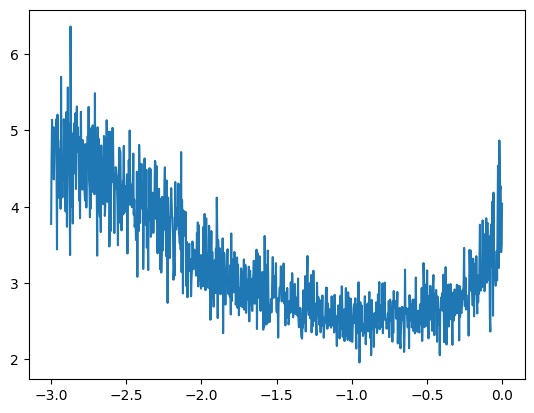

In [85]:
plt.plot(lri, lossi)

In [86]:
## more parameters model have more the possibility of overfitting
## how to make it convenient

In [ ]:
## training_split, dev/validation split, test_split

## 80% , 10% , 10%

In [89]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, ytr = build_dataset(words[:n1])
Xdev, ydev = build_dataset(words[n1:n2])
Xte, yte = build_dataset(words[n2:])

In [90]:
len(words), n1, n2, n2-n1

(32033, 25626, 28829, 3203)

In [ ]:
## reset parameters of neural network

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters)

In [95]:
lri = []
lossi = []

for _ in range(10000):

  ## minibatch
  ix = torch.randint(0, Xtr.shape[0], (32,))

  ## forward pass
  emb = C[X[ix]] ## [32, 3, 2]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) ## (32 ,100)
  logits = h @ W2 + b2 ## (32, 27)
  loss = F.cross_entropy(logits, ytr[ix])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  ## update
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

print(loss.item())

2.790403127670288


In [96]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, ydev)
loss

tensor(2.8229, grad_fn=<NllLossBackward0>)

In [97]:
emb = C[Xte]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, yte)
loss

tensor(2.8245, grad_fn=<NllLossBackward0>)

In [98]:
## validation loss and test loss are nearly equal
## that sign's we are not overfitting
## the model is underfitting there are less number of parameters
## we need to increase the number of parameter

In [107]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [108]:
sum(p.nelement() for p in parameters)

10281

In [110]:
for p in parameters:
  p.requires_grad = True

In [120]:
lri = []
lossi = []
stepi = []

for i in range(30000):

  ## minibatch
  ix = torch.randint(0, Xtr.shape[0], (32,))

  ## forward pass
  emb = C[X[ix]] ## [32, 3, 2]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) ## (32 ,100)
  logits = h @ W2 + b2 ## (32, 27)
  loss = F.cross_entropy(logits, ytr[ix])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  ## update
  lr = 0.1
  for p in parameters:
    p.data += -lr * p.grad

  ## track status
  # lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.item())

print(loss.item())

2.917642116546631


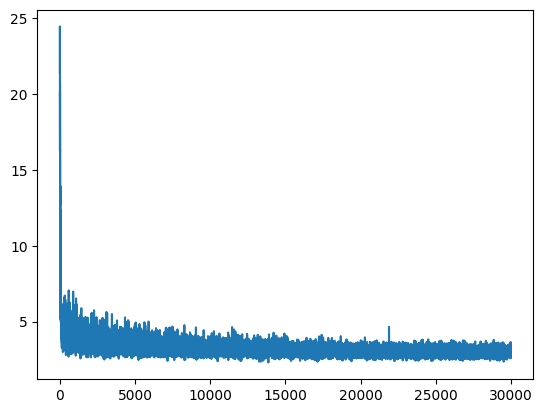

In [112]:
plt.plot(stepi, lossi)

In [121]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, ydev)
loss

tensor(2.8718, grad_fn=<NllLossBackward0>)

In [122]:
emb = C[Xte]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, yte)
loss

tensor(2.8721, grad_fn=<NllLossBackward0>)

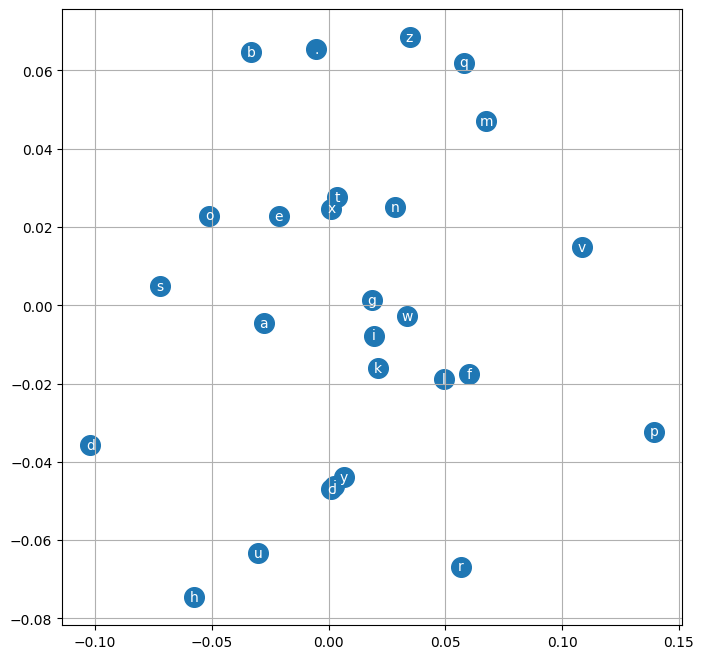

In [123]:
## visualize embeddings train by the neural network

plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [124]:
## this is not improving the loss

# bottleneck here may be embedding size of each character --. write now it is 2
## let's make it 10 and look at the performance


In [125]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [126]:
lri = []
lossi = []
stepi = []

In [129]:
for p in parameters:
  p.requires_grad = True

In [135]:

for i in range(50000):

  ## minibatch
  ix = torch.randint(0, Xtr.shape[0], (32,))

  ## forward pass
  emb = C[X[ix]] ## [32, 3, 2]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) ## (32 ,100)
  logits = h @ W2 + b2 ## (32, 27)
  loss = F.cross_entropy(logits, ytr[ix])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  ## update
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  ## track status
  # lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

2.7549118995666504


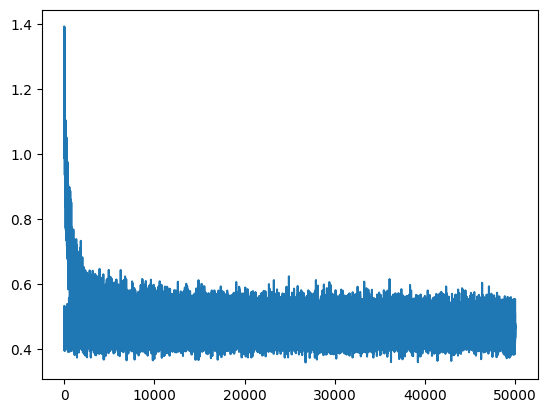

In [136]:
plt.plot(stepi, lossi)

In [137]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, ydev)
loss

tensor(2.8585, grad_fn=<NllLossBackward0>)

In [138]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, ydev)
loss

tensor(2.8585, grad_fn=<NllLossBackward0>)

In [ ]:
# let's decreate the learning rate to 0.01 and iterate more 50000 times

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [140]:
## sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

erraaimyazhheelmndhryalarethrsjdhdrlrg.
aiehedieliihnmp.
oealeieiseananarneltzimhlkaain.
sadbvrgahimies.
.
n.
ir.
eelklxntpooanu.
amnedar.
yirlemehs.
lmajm.
sknyaaahya.
nalyansun.
zajrlvjiren.
.
rt.
ns.
eaoec.
noadbrfhnkoeoehngpeihasatteyyh.
hmreollii.


In [ ]:
# this is working for karpathy not for me ...
## i need to experiment more with parameters

##experiments
## neural parameters
## character passed as context
## embedding size
## learing rate
## number of iteration
## ..

## i 'm hoping hyperparameter tuning lead me to good results